 # Yelp K-means clustering 

 ## Import libraries  

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import pyspark
from pyspark import sql
import re
import pandas as pd
import numpy as np


 ## Create spark session

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


 ## Load datasets

In [3]:
#path_business = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_business.json'
#path_review = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_review.json'
path_user = '/Users/yao/Desktop/IST718/project/ist_718_big_data_yelp_project/yelp-dataset/yelp_academic_dataset_user.json'
#business_df = spark.read.json(path_business)
#review_df = spark.read.json(path_review)
user_df = spark.read.json(path_user)

In [4]:
#business_df.count()
#review_df.count()
#business_df.toPandas().head(5)

user_df = user_df.sample(False, 0.02, 0)




In [7]:
dir(sc)

['PACKAGE_EXTENSIONS',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accumulatorServer',
 '_active_spark_context',
 '_batchSize',
 '_callsite',
 '_checkpointFile',
 '_conf',
 '_dictToJavaMap',
 '_do_init',
 '_encryption_enabled',
 '_ensure_initialized',
 '_gateway',
 '_getJavaStorageLevel',
 '_initialize_context',
 '_javaAccumulator',
 '_jsc',
 '_jvm',
 '_lock',
 '_next_accum_id',
 '_pickled_broadcast_vars',
 '_python_includes',
 '_repr_html_',
 '_serialize_to_jvm',
 '_temp_dir',
 '_unbatched_serializer',
 'accumulator',
 'addFile',
 'addPyFile',
 'appName',
 'applicationId',
 'binaryFiles',
 'binaryRecords',
 'broadcas

In [10]:
#user_df.count()
user_df.printSchema()



root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [34]:
user_df.toPandas().head(5)
#check if there are null value in yelping_since
from pyspark.sql.functions import isnan
user_df.filter((user_df["yelping_since"] == "") | user_df["yelping_since"].isNull() | isnan(user_df["yelping_since"])).count()



0

# Data Cleaning

## Calculate the difference date from current date to yelping_since

In [5]:
from pyspark.sql.functions import datediff, lit
from pyspark.sql.functions import udf

@udf
def date(time):
    time = time[0:10]
    return time
    
user_df = user_df.withColumn("yelping_date", date('yelping_since'))

#user_df.toPandas().head(5)
user_df1 = user_df.select('average_stars','fans','funny','review_count','useful','yelping_date',lit("2019-12-03").alias('current_date'))
user_df1 = user_df1.withColumn('days',datediff("current_date", "yelping_date"))
columns_to_drop = ['current_date', 'yelping_date']
user_df1 = user_df1.drop(*columns_to_drop)
#user_df1 = user_df1.drop('current_date').collect()
user_df1.toPandas().head(5)


,average_stars,fans,funny,review_count,useful,days
0,3.89,99,1661,1563,4172,2232
1,3.88,72,610,178,1125,2830
2,3.92,103,889,933,2859,3559
3,1.00,0,0,1,0,2102
4,3.43,1,1,6,2,2905


## Convert all data columns into float

In [6]:
user_df1.printSchema()
user_df2 = user_df1.select(*(user_df1[c].cast("float").alias(c) for c in user_df1.columns[0:]))
user_df2.show(5)

root
 |-- average_stars: double (nullable = true)
 |-- fans: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- days: integer (nullable = true)

+-------------+-----+------+------------+------+------+
|average_stars| fans| funny|review_count|useful|  days|
+-------------+-----+------+------------+------+------+
|         3.89| 99.0|1661.0|      1563.0|4172.0|2232.0|
|         3.88| 72.0| 610.0|       178.0|1125.0|2830.0|
|         3.92|103.0| 889.0|       933.0|2859.0|3559.0|
|          1.0|  0.0|   0.0|         1.0|   0.0|2102.0|
|         3.43|  1.0|   1.0|         6.0|   2.0|2905.0|
+-------------+-----+------+------------+------+------+
only showing top 5 rows



## Check null value in dataset

In [65]:
#user_df2.filter((user_df2["average_stars"] == "") | user_df["average_stars"].isNull() | isnan(user_df["average_stars"])).count()
#user_df2.filter((user_df2["fans"] == "") | user_df["fans"].isNull() | isnan(user_df["fans"])).count()
#user_df2.filter((user_df2["funny"] == "") | user_df["funny"].isNull() | isnan(user_df["funny"])).count()
#user_df2.filter((user_df2["review_count"] == "") | user_df["review_count"].isNull() | isnan(user_df["review_count"])).count()
#user_df2.filter((user_df2["useful"] == "") | user_df["useful"].isNull() | isnan(user_df["useful"])).count()


0

 ## Using MinMaxScaler to make the values between 0 and 1

In [7]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
Assembler = VectorAssembler(inputCols=["average_stars", "fans","funny","review_count","useful","days"], outputCol="features")
transformed = Assembler.transform(user_df2)
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalermodel = scaler.fit(transformed.select("features"))
df_kmeans = scalermodel.transform(transformed)




In [8]:
df_kmeans.toPandas().head(5)

,average_stars,fans,funny,review_count,useful,days,features,scaledFeatures
0,3.89,99.0,1661.0,1563.0,4172.0,2232.0,"[3.890000104904175, 99.0, 1661.0, 1563.0, 4172...","[0.7225000262260437, 0.01037953449360453, 0.08..."
1,3.88,72.0,610.0,178.0,1125.0,2830.0,"[3.880000114440918, 72.0, 610.0, 178.0, 1125.0...","[0.7200000286102295, 0.007548752358985112, 0.0..."
2,3.92,103.0,889.0,933.0,2859.0,3559.0,"[3.9200000762939453, 103.0, 889.0, 933.0, 2859...","[0.7300000190734863, 0.010798909624659257, 0.0..."
3,1.00,0.0,0.0,1.0,0.0,2102.0,"[1.0, 0.0, 0.0, 1.0, 0.0, 2102.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.33404627649231966]"
4,3.43,1.0,1.0,6.0,2.0,2905.0,"[3.430000066757202, 1.0, 1.0, 6.0, 2.0, 2905.0]","[0.6075000166893005, 0.00010484378276368212, 5..."


## split into train and test

In [9]:
training_kmeans,test_kmeans = df_kmeans.randomSplit([0.8,0.2],0)

# Find the best K in classifier

In [15]:
from pyspark.ml.clustering import KMeans
cost = np.zeros(16)
for k in range(2,16):
    print(k)
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) 

2
3
4
5
6
7
8
9
10
11
12
13
14
15


Text(0, 0.5, 'cost')

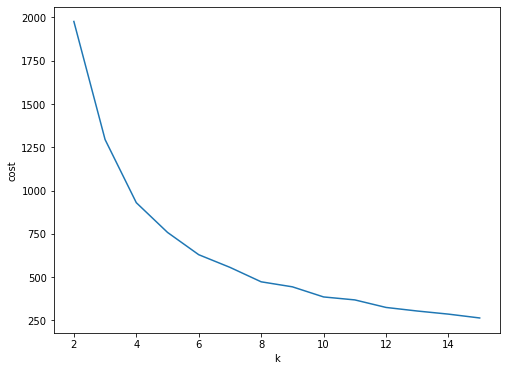

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,16),cost[2:16])
ax.set_xlabel('k')
ax.set_ylabel('cost')

# Train the learning model

In [17]:
k = 6
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[6.81000951e-01 9.10453241e-05 3.32672350e-04 4.79718523e-03
 7.82607193e-04 2.44802987e-01]
[9.07401076e-01 1.17289660e-04 3.56342066e-04 4.15750416e-03
 8.02822554e-04 4.64247884e-01]
[4.45481551e-02 3.80296398e-06 3.22143052e-05 2.98715013e-04
 9.71435083e-05 2.33508462e-01]
[9.68685989e-01 1.79186358e-05 3.71041828e-05 1.02194673e-03
 1.07871254e-04 1.86444410e-01]
[0.6621934  0.00074121 0.00368577 0.01683078 0.0055236  0.59558206]
[4.15218328e-01 2.93924202e-05 1.94541306e-04 2.23200973e-03
 4.36122493e-04 3.45017703e-01]


In [21]:
df_pred = model.transform(df_kmeans).select('average_stars','review_count','days', 'prediction')
df_pred.show(5)
#rows = transformed.collect()
#print(rows[:3])

+-------------+------------+------+----------+
|average_stars|review_count|  days|prediction|
+-------------+------------+------+----------+
|         3.89|      1563.0|2232.0|         0|
|         3.88|       178.0|2830.0|         4|
|         3.92|       933.0|3559.0|         4|
|          1.0|         1.0|2102.0|         2|
|         3.43|         6.0|2905.0|         4|
+-------------+------------+------+----------+
only showing top 5 rows



In [33]:
pred_pd = df_pred.toPandas()
#pred_pd['review_count'].max()
pred_pd = pred_pd.drop(pred_pd[pred_pd.review_count == 4027.0].index)
pred_pd['review_count'].max()

2277.0

# Visualize the results

## Average_star, review_count, days

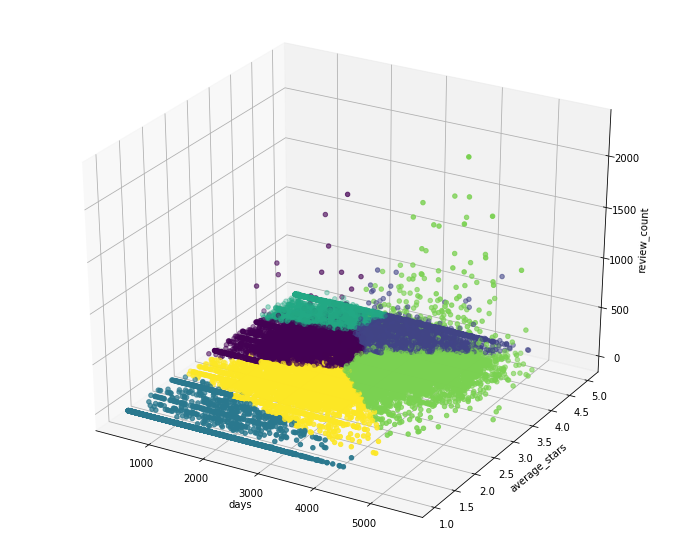

In [43]:
from mpl_toolkits.mplot3d import Axes3D

threed = plt.figure(figsize=(12,10)).gca(projection='3d')
threed.scatter(pred_pd.days, pred_pd.average_stars,pred_pd.review_count, c=pred_pd.prediction)
threed.set_ylabel('average_stars')
threed.set_zlabel('review_count')
threed.set_xlabel('days')
plt.show()

## Days, aveage_stars, fans

In [35]:
df_pred1 = model.transform(df_kmeans).select('average_stars','fans','days', 'prediction')
pred_pd1 = df_pred1.toPandas()

pred_pd1 = pred_pd1.drop(pred_pd1[pred_pd1.fans == 9538.0].index)
pred_pd1['fans'].max()

1340.0

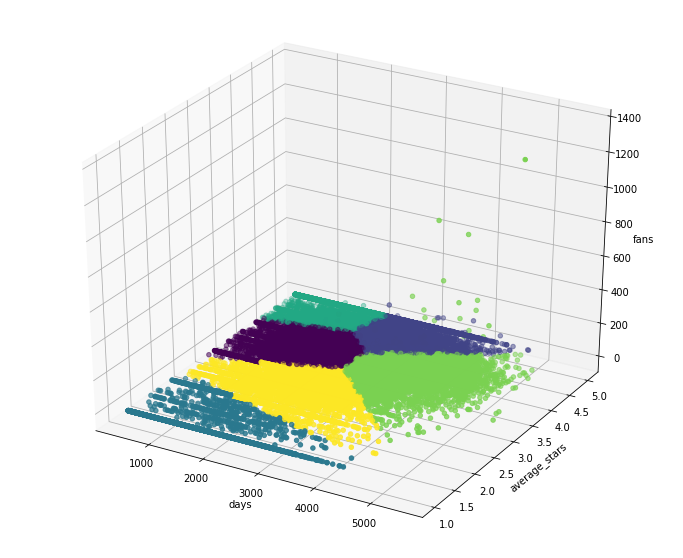

In [44]:
threed1 = plt.figure(figsize=(12,10)).gca(projection='3d')
threed1.scatter( pred_pd1.days, pred_pd1.average_stars, pred_pd1.fans, c=pred_pd1.prediction)
threed1.set_ylabel('average_stars')
threed1.set_zlabel('fans')
threed1.set_xlabel('days')
plt.show()

In [46]:
df_pred2 = model.transform(df_kmeans).select('average_stars','useful','funny', 'prediction')
pred_pd2 = df_pred2.toPandas()

pred_pd2 = pred_pd2.drop(pred_pd2[pred_pd2.useful > 5000.0].index)
pred_pd2 = pred_pd2.drop(pred_pd2[pred_pd2.useful == 0].index)
pred_pd2 = pred_pd2.drop(pred_pd2[pred_pd2.funny == 0].index)


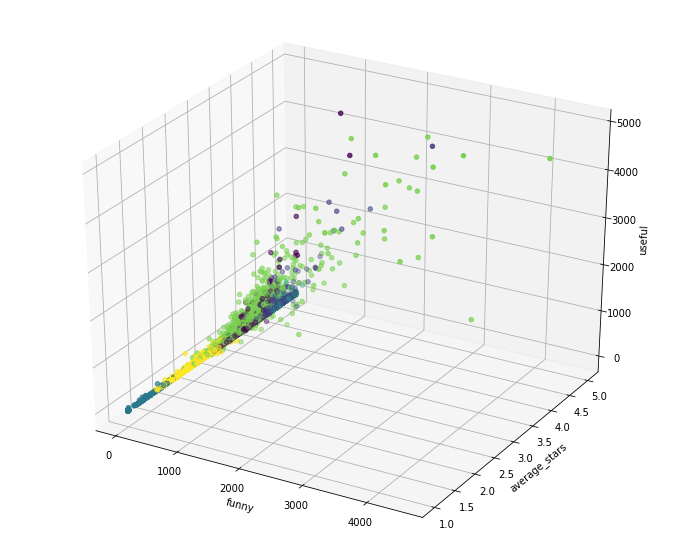

In [48]:
threed2 = plt.figure(figsize=(12,10)).gca(projection='3d')
threed2.scatter(pred_pd2.funny, pred_pd2.average_stars, pred_pd2.useful, c=pred_pd2.prediction)
threed2.set_ylabel('average_stars')
threed2.set_zlabel('useful')
threed2.set_xlabel('funny')
plt.show()